In [1]:
%matplotlib inline

import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from torch.utils.data import DataLoader
import torch
from typing import List, Literal, Dict, Union, Tuple
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
import re

from predpy.dataset import MultiTimeSeriesDataset
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import plot_anomalies, get_ids_ranges, get_cls_ids_ranges
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_dataset_names, load_anom_scores, MovingStdAD)

from notebook_utils.modeling import (
    predict, get_a_scores, get_rec_fbeta_score_conf_mat,
    get_a_scores_one_per_point, get_recon_one_per_point,
    adjust_point_cls_with_window,
    th_ws_experiment, stats_experiment,
    calculate_rec_wdd, recalculate_wdd
)
from notebook_utils.plotting import (
    plot_scores, plot_kde, plot_dataset, plot_scores_and_bands
)
from notebook_utils.save_load import (
    save_th_exp, load_th_exp
)
from notebook_utils.ts_stats import (
    get_bollinger, get_std, get_diff
)


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

In [2]:
def a_score_exp(
    train_dl: DataLoader, test_dl: DataLoader,
    exp: Experimentator, scale: bool, models_ids: List = None
) -> Dict:
    res = {}
    if models_ids is None:
        models_ids = exp.models_params.index
    else:
        assert all(item in exp.models_params.index for item in models_ids)
    for m_id in tqdm(models_ids):
        m_name = exp.models_params.loc[m_id]['name_']
        model = exp.load_pl_model(m_id, f'checkpoints/{ds_name}/{m_name}')
        if scale:
            train_a_scores = model.fit_scores_scaler(
                train_dl, use_tqdm=False)
        else:
            train_a_scores = get_a_scores(
                model=model, dataloader=train_dl, use_tqdm=False)

        test_a_scores = get_a_scores(
            model, test_dl, scale=scale, use_tqdm=False)
        res[m_name] = [train_a_scores, test_a_scores]
    return res

def exctract_a_scores(
    exps_a_scores: Union[Dict, List[Dict]],
    train_len: int = None, test_len: int = None):
    if not (isinstance(exps_a_scores, List) or isinstance(exps_a_scores, Tuple)):
        exps_a_scores = [exps_a_scores]
    
    train_a_scores = {}
    test_a_scores = {}
    for e_a_s in exps_a_scores:
        for m_name, scores in e_a_s.items():
            train_a_s = np.copy(scores[0])
            test_a_s = np.copy(scores[1])
            if train_len is not None and len(train_a_s) < train_len:
                n_padding = train_len - len(train_a_s)
                train_a_s = np.concatenate([np.zeros((n_padding, 1)), train_a_s])
            if test_len is not None and len(test_a_s) < test_len:
                # old = scores[1]
                n_padding = test_len - len(test_a_s)
                test_a_s = np.concatenate([np.zeros((n_padding, 1)), test_a_s])
            train_a_scores[m_name] = train_a_s
            test_a_scores[m_name] = test_a_s
    return train_a_scores, test_a_scores

## Loading data

In [3]:
topic, colleciton_name, ds_name = 'Handmade', 'Sin', 'artificial_1'
window_size = 200

In [4]:
train_ds = get_dataset(
    f'data/{topic}/{colleciton_name}/train/{ds_name}.csv',
    window_size=window_size)
test_ds = get_dataset(
    f'data/{topic}/{colleciton_name}/test/{ds_name}.csv',
    window_size=window_size)

train_dl = DataLoader(train_ds, batch_size=500)
test_dl = DataLoader(test_ds, batch_size=500)
test_index = test_ds.sequences[0].index

test_point_cls_path = f'data/{topic}/{colleciton_name}/test_label/{ds_name}.csv'
test_point_cls = pd.read_csv(
    test_point_cls_path, header=None)\
    .iloc[:, 0].to_numpy()

n_features = train_ds.n_points
point_anoms_ranges = get_cls_ids_ranges(test_ds.sequences[0].index, test_point_cls)

# Testing models on sin dataset

## Calculating a_scores

In [14]:
exp1 = load_experimentator('./saved_experiments/2022-06-11_22:59:43.pkl')
exp1.models_params['name_']

0                 LSTMMVR_h50_z10_l1
1           Conv_ws200_nk10_ks3_es50
2                    VELC_h50_l1_z10
3    TadGAN_h100_l2_z20_g1d1_warmup0
4          AnomTrans_l3_d512_lambda3
Name: name_, dtype: object

In [6]:
exp1_a_scores = a_score_exp(
    train_dl, test_dl, exp1, scale=True, models_ids=[0, 1, 2, 4])

100%|██████████| 4/4 [04:03<00:00, 60.95s/it]


In [5]:
exp2 = load_experimentator('./saved_experiments/2022-06-12_01:00:49.pkl')
exp2.models_params['name_']

0    TadGAN_h50_l1_z10_g1d1_warmup0
1          AnomTrans_l1_d10_lambda3
Name: name_, dtype: object

In [9]:
train_a_scores, test_a_scores = exctract_a_scores(
    [exp1_a_scores, exp2_a_scores], train_len=train_ds.n_points, test_len=test_ds.n_points)

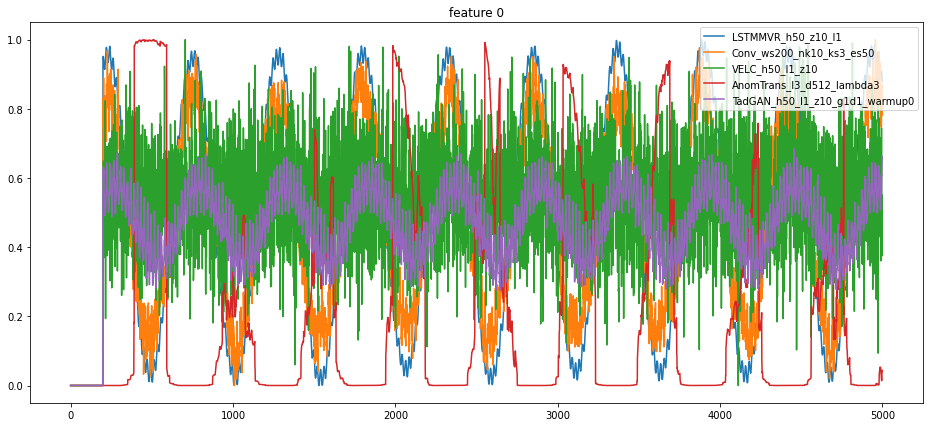

In [10]:
plot_dataset(train_a_scores, figsize=(16, 7));

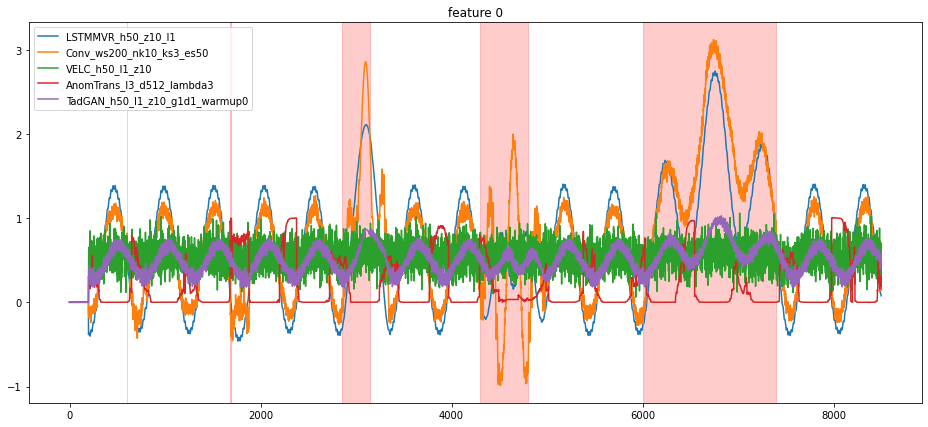

In [11]:
plot_dataset(
    test_a_scores, figsize=(16, 7),
    anoms_vrects=point_anoms_ranges);

## Plot scores separately

### Train scores

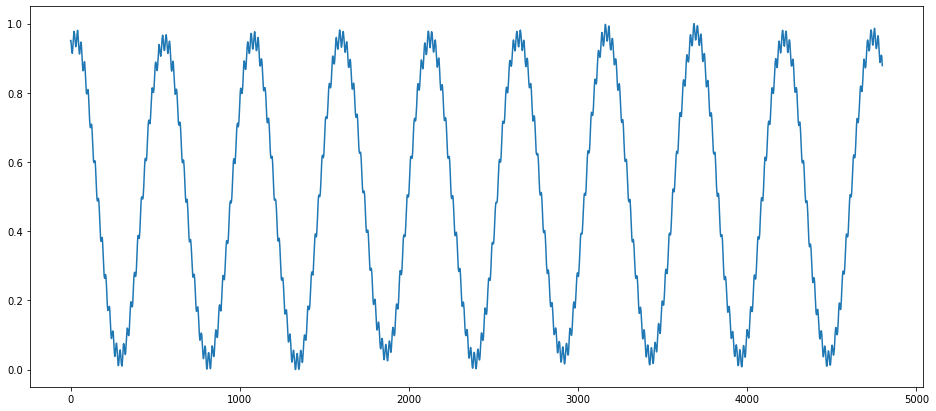

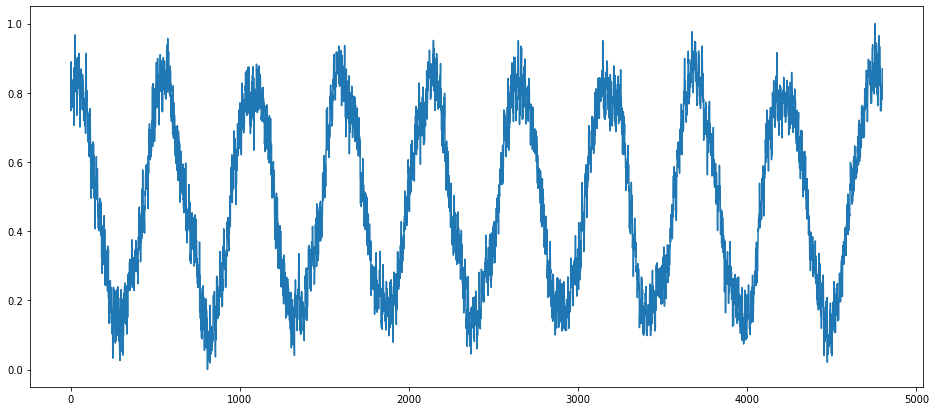

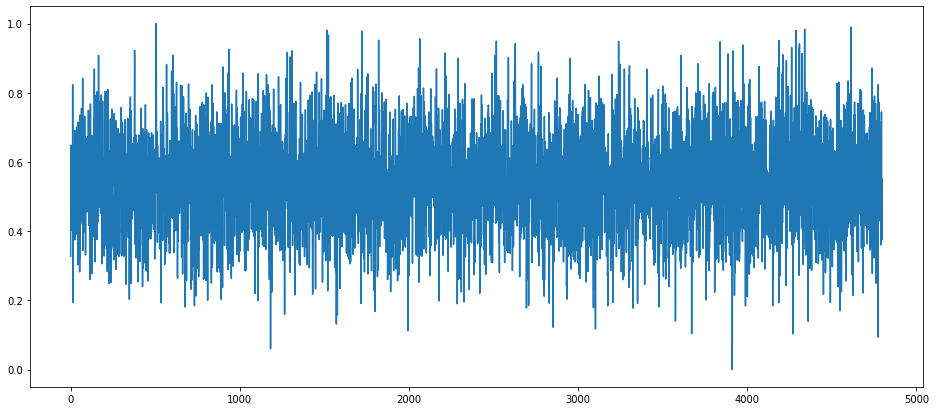

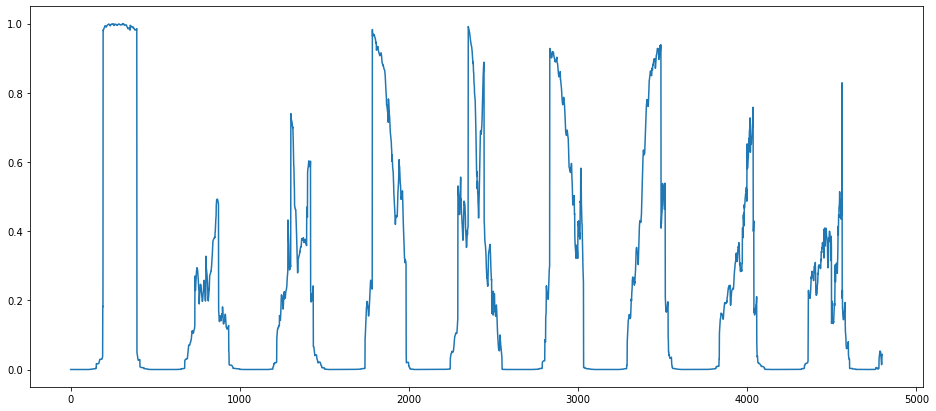

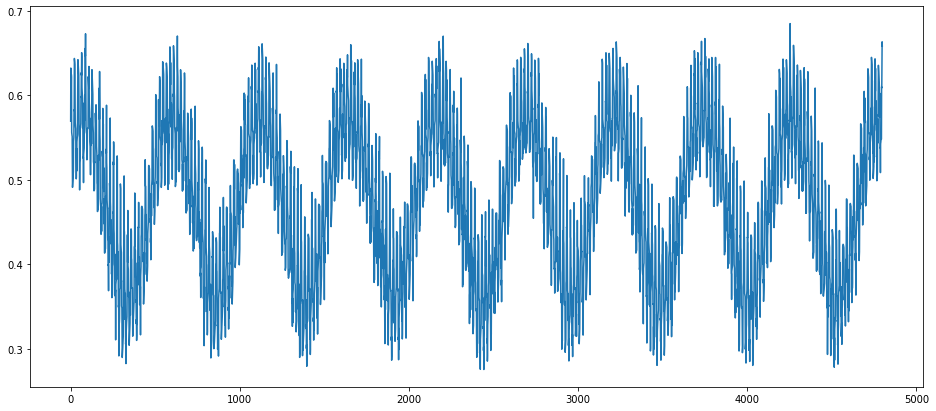

In [90]:
for m_name, a_scores in train_a_scores.items():
    plot_dataset(
        {m_name: a_scores[200:]}, figsize=(16, 7), show_f_name=False, show_legend=False);

### Test dataset

In [54]:
m_name = 'AnomTrans_l3_d512_lambda3'
model = exp1.load_pl_model(4, f'checkpoints/{ds_name}/{m_name}')
at_a_scores = get_a_scores_one_per_point(model, DataLoader(test_ds, batch_size=1), window_size, return_only_point_a_scores=True)

100%|██████████| 8301/8301 [00:06<00:00, 1351.03it/s]


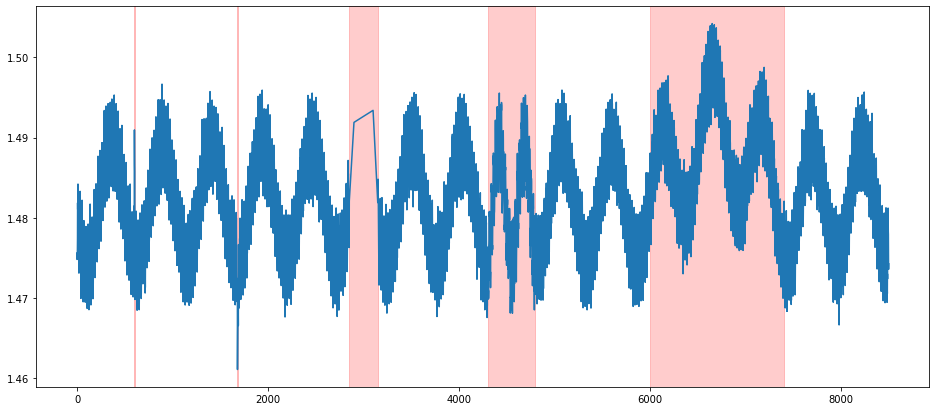

In [93]:
plot_dataset(
    {'AnomTrans_l3_d512_lambda3': at_a_scores}, figsize=(16, 7),
    anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

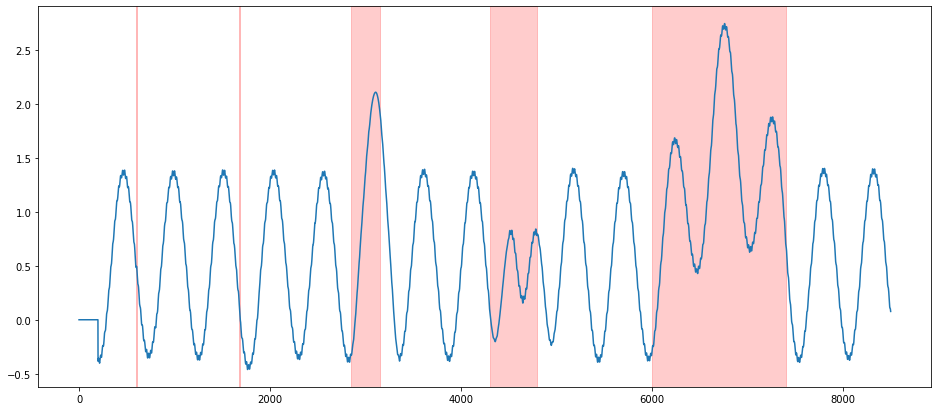

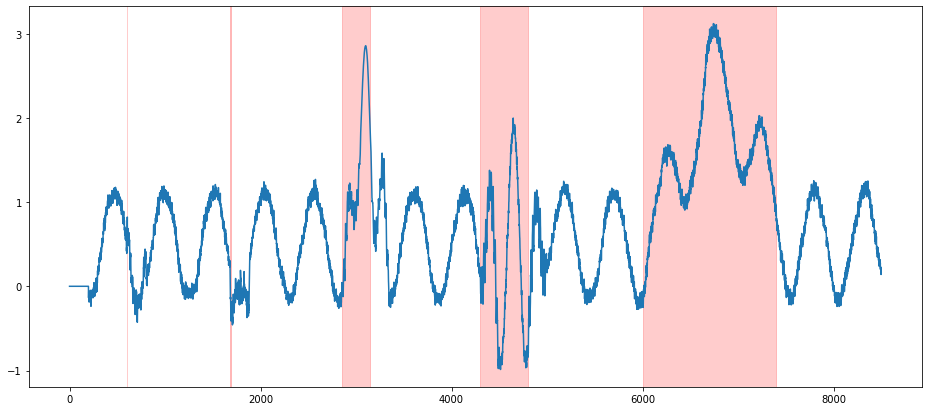

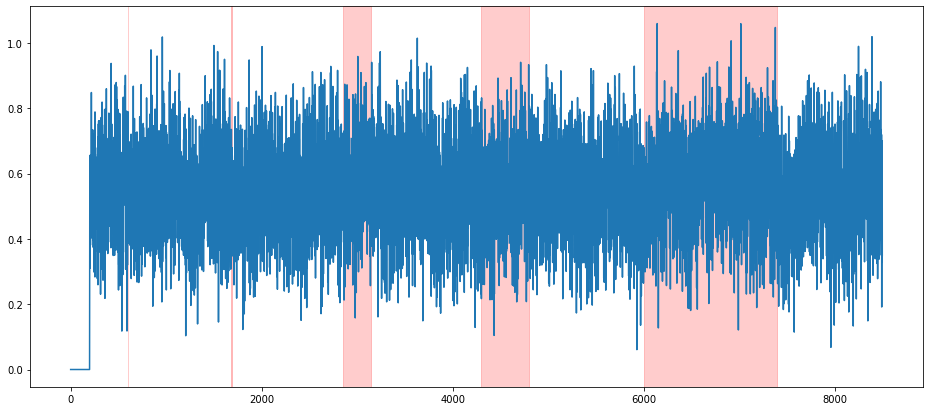

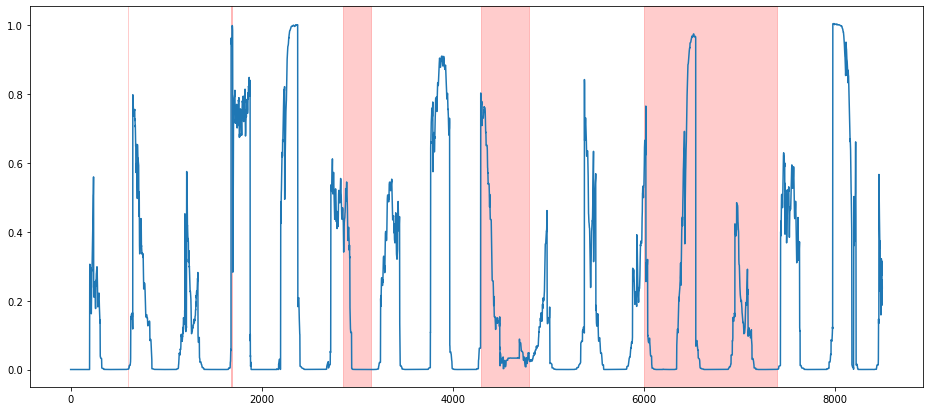

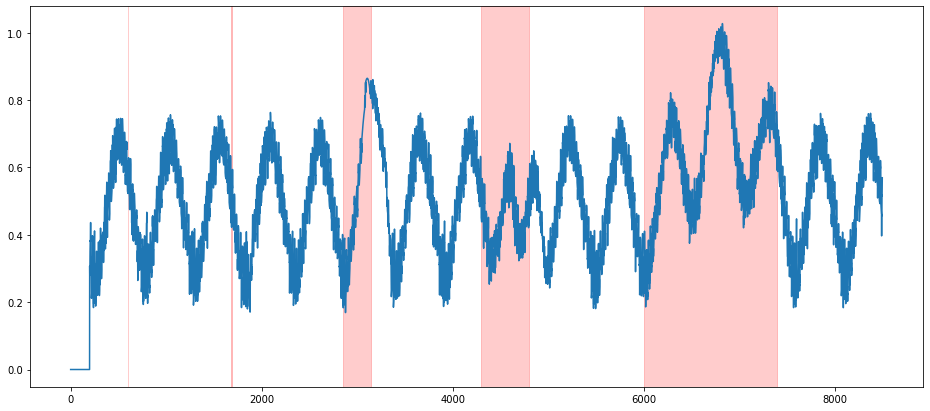

In [91]:
for m_name, a_scores in test_a_scores.items():
    plot_dataset(
        {m_name: a_scores}, figsize=(16, 7),
        anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

# Additional experiments

## Testing AnomTrans_l1_d10_lambda3

In [31]:
exp2_2_a_scores = a_score_exp(
    train_dl, test_dl, exp2, scale=False, models_ids=[1])

100%|██████████| 1/1 [00:18<00:00, 18.59s/it]


In [32]:
train2_2_a_scores, test2_2_a_scores = exctract_a_scores(
    [exp2_2_a_scores], train_len=train_ds.n_points, test_len=test_ds.n_points)

In [7]:
m_name = 'AnomTrans_l1_d10_lambda3'
model = exp2.load_pl_model(1, f'checkpoints/{ds_name}/{m_name}')

In [8]:
model.fit_scores_scaler(
    train_dl, use_tqdm=False);

100%|██████████| 8301/8301 [00:05<00:00, 1458.58it/s]


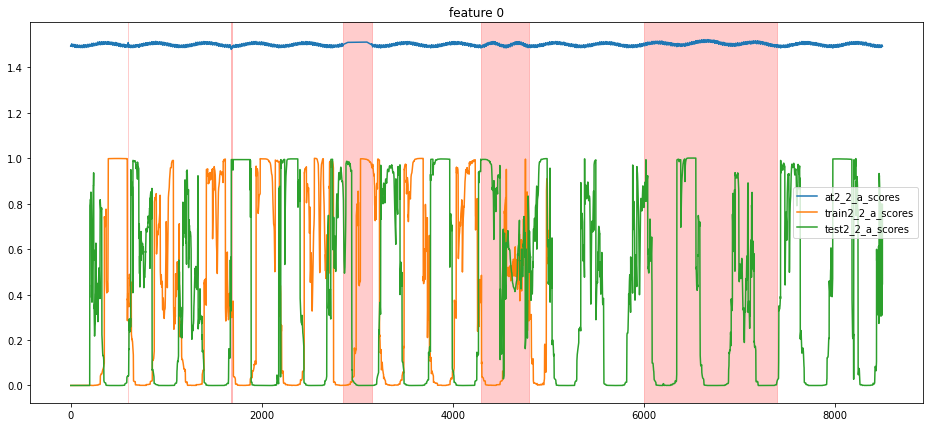

In [17]:
at2_2_a_scores = get_a_scores_one_per_point(
    model, DataLoader(test_ds, batch_size=1), window_size, return_only_point_a_scores=True, scale=False)
plot_dataset(
    {
        'at2_2_a_scores': at2_2_a_scores,
        'train2_2_a_scores': train2_2_a_scores['AnomTrans_l1_d10_lambda3'],
        'test2_2_a_scores': test2_2_a_scores['AnomTrans_l1_d10_lambda3']
    },
    figsize=(16, 7),
    anoms_vrects=point_anoms_ranges);

In [9]:
at2_2_train_point_a_scores = get_a_scores_one_per_point(
    model, DataLoader(train_ds, batch_size=1), window_size, return_only_point_a_scores=True, scale=True)

100%|██████████| 4801/4801 [00:03<00:00, 1423.47it/s]


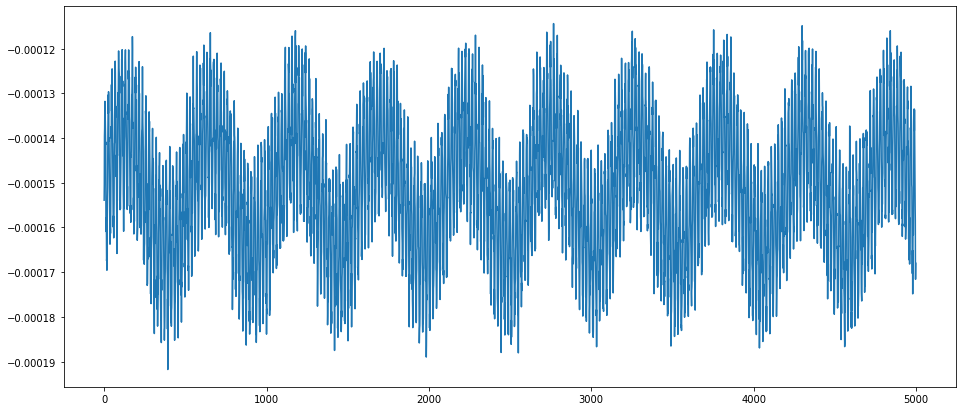

In [11]:
plot_dataset(
    {'at2_2_train_point_a_scores': at2_2_train_point_a_scores},
    figsize=(16, 7), show_f_name=False, show_legend=False);

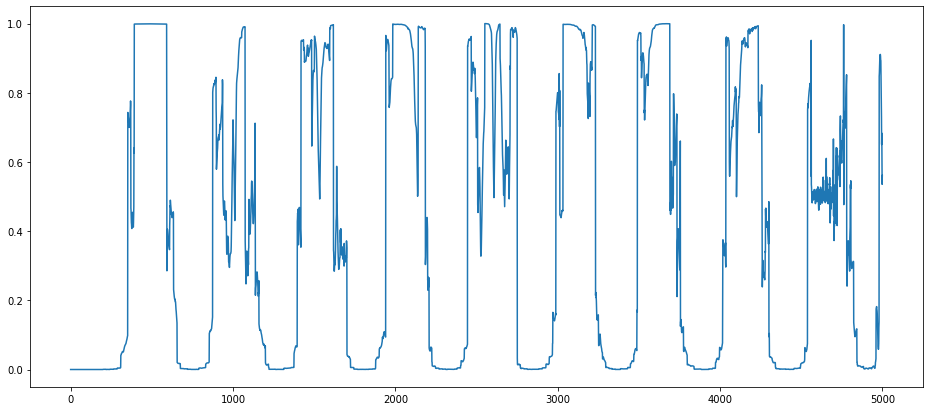

In [13]:
plot_dataset(
    {'train2_2_a_scores': train2_2_a_scores['AnomTrans_l1_d10_lambda3']},
    figsize=(16, 7), show_f_name=False, show_legend=False);

{'AnomTrans_l1_d10_lambda3': array([[  0.        ],
        [  0.        ],
        [  0.        ],
        ...,
        [ 93.28414154],
        [237.90635681],
        [133.98547363]])}

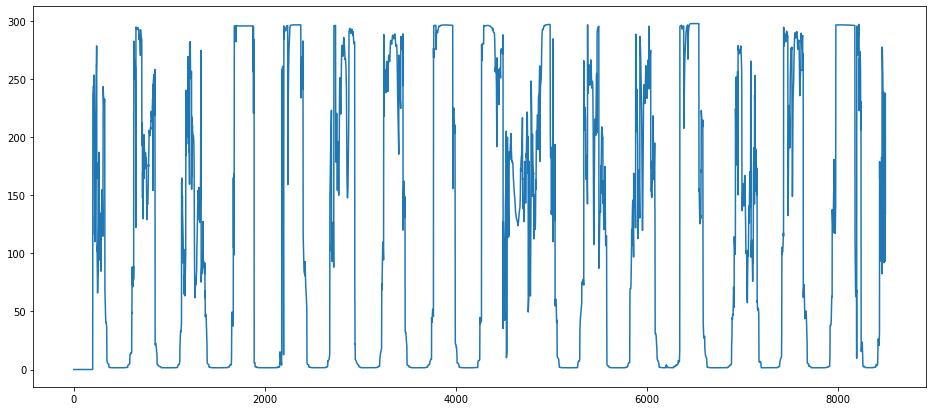

In [34]:
plot_dataset(
    {'test2_2_a_scores': test2_2_a_scores['AnomTrans_l1_d10_lambda3']},
    figsize=(16, 7), show_f_name=False, show_legend=False);

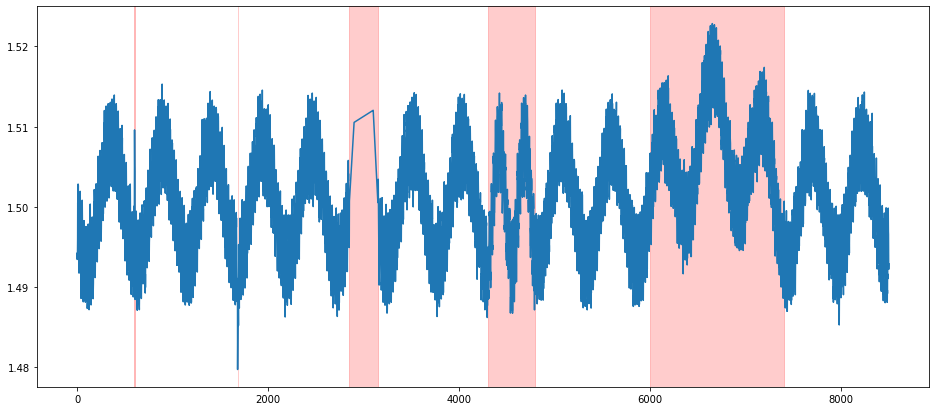

In [18]:
plot_dataset(
    {'at2_2_a_scores': at2_2_a_scores,},
    figsize=(16, 7),
    anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

In [25]:
tmp = pd.DataFrame(at2_2_a_scores).rolling(window_size).max().dropna().to_numpy()

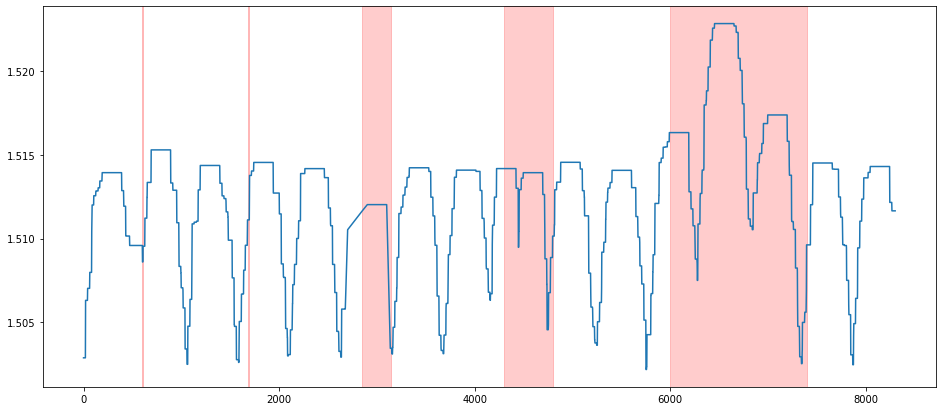

In [26]:
plot_dataset(
    {'test2_2_a_scores': tmp},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

### AnomTrans_l1_d10_lambda10
Lambda is changed from 3 to 10

In [9]:
exp3 = load_experimentator('./saved_experiments/2022-06-13_00:27:58.pkl')
exp3.models_params['name_']

0    AnomTrans_l1_d10_lambda3
Name: name_, dtype: object

In [10]:
exp3_a_scores = a_score_exp(
    train_dl, test_dl, exp3, scale=True, models_ids=[0])

100%|██████████| 1/1 [00:20<00:00, 20.91s/it]


In [11]:
train3_a_scores, test3_a_scores = exctract_a_scores(
    [exp3_a_scores], train_len=train_ds.n_points, test_len=test_ds.n_points)

In [12]:
m_name = 'AnomTrans_l1_d10_lambda3'
model = exp3.load_pl_model(0, f'checkpoints/{ds_name}/{m_name}')

In [14]:
at3_a_scores = get_a_scores_one_per_point(model, DataLoader(test_ds, batch_size=1), window_size, return_only_point_a_scores=True, scale=False)

100%|██████████| 8301/8301 [00:06<00:00, 1294.61it/s]


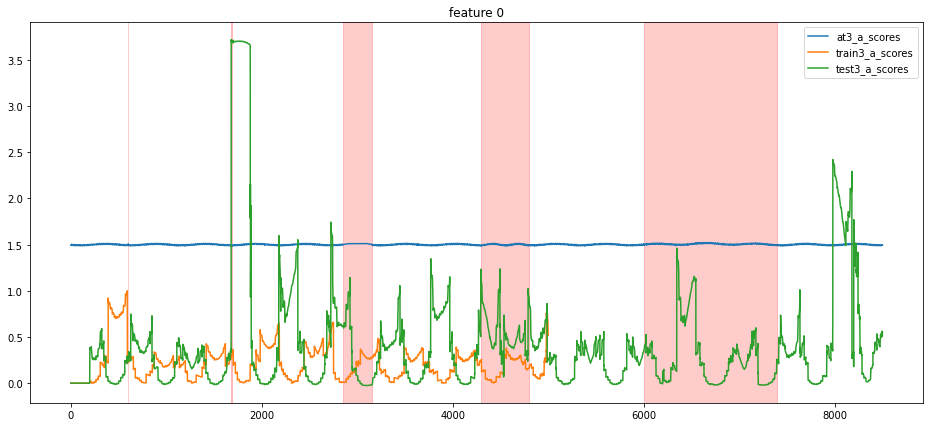

In [15]:
plot_dataset(
    {
        'at3_a_scores': at3_a_scores,
        'train3_a_scores': train3_a_scores['AnomTrans_l1_d10_lambda3'],
        'test3_a_scores': test3_a_scores['AnomTrans_l1_d10_lambda3']
    },
    figsize=(16, 7),
    anoms_vrects=point_anoms_ranges);

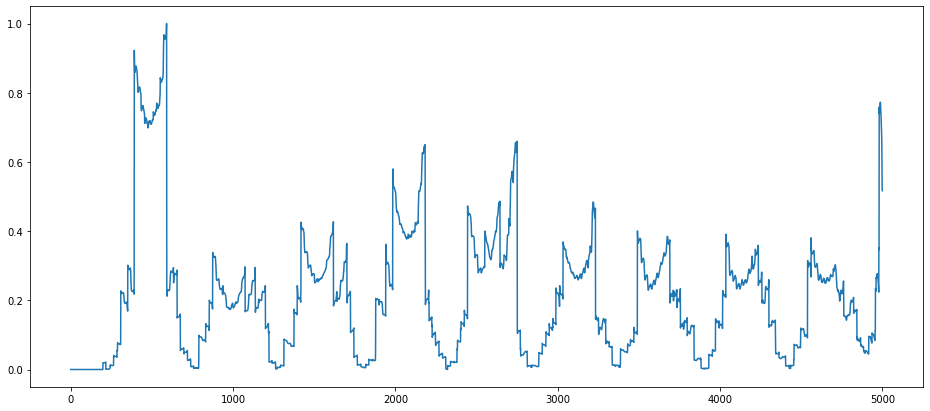

In [16]:
plot_dataset(
    {'train3_a_scores': train3_a_scores['AnomTrans_l1_d10_lambda3']},
    figsize=(16, 7), show_f_name=False, show_legend=False);

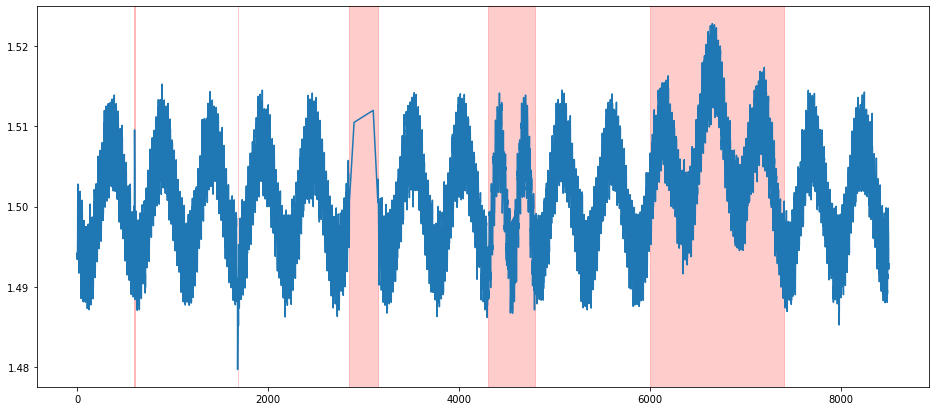

In [17]:
plot_dataset(
    {'at3_a_scores': at3_a_scores,},
    figsize=(16, 7),
    anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

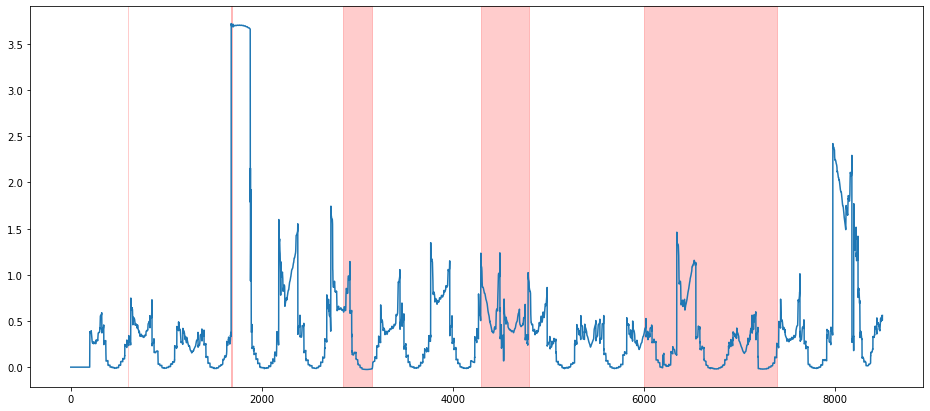

In [18]:
plot_dataset(
    {'test3_a_scores': test3_a_scores['AnomTrans_l1_d10_lambda3']},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

In [24]:
point_max = pd.DataFrame(at3_a_scores).rolling(window_size).max().fillna(1.5).to_numpy()

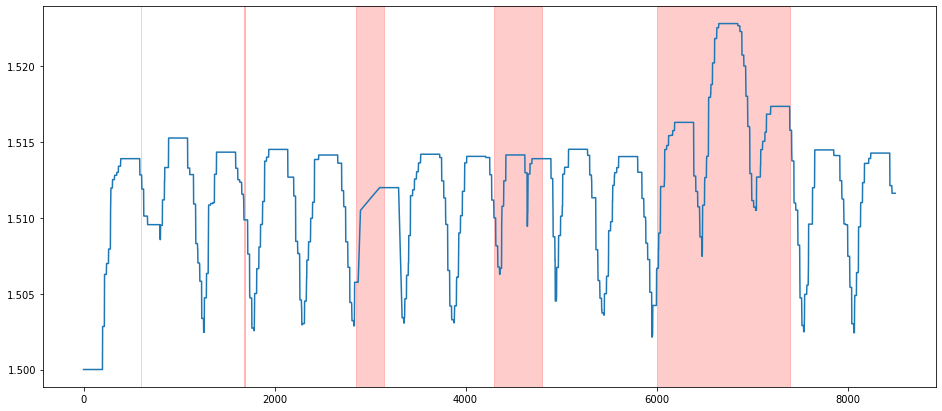

In [25]:
plot_dataset(
    {'test3_a_scores': point_max},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

In [30]:
recs = get_a_scores(model, test_dl, scale=False, return_only_point_a_scores=True)

100%|██████████| 17/17 [00:11<00:00,  1.43it/s]


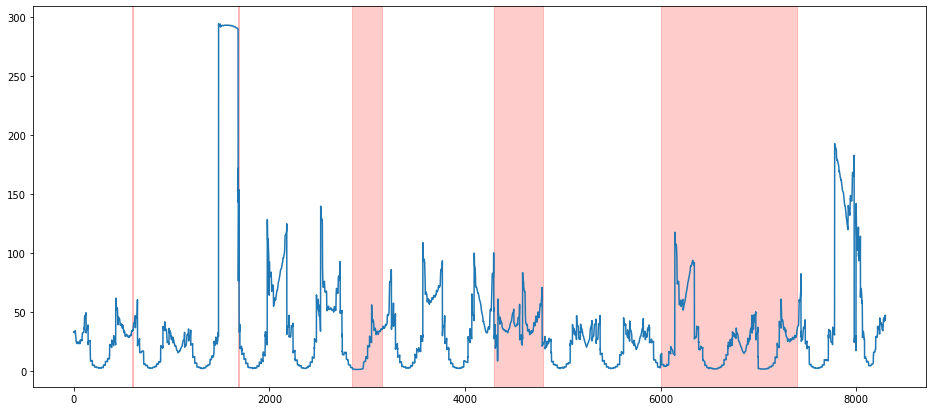

In [38]:
rec_max = np.max(recs, axis=1).reshape(-1, 1)
plot_dataset(
    {'test3_a_scores': rec_max},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

### AnomTrans_l1_d3_lambda10
Lambda is changed from 3 to 10

In [5]:
exp4 = load_experimentator('./saved_experiments/2022-06-13_16:08:01.pkl')
exp4.models_params['name_']

0    AnomTrans_l1_d3_lambda10
Name: name_, dtype: object

In [6]:
exp4_a_scores = a_score_exp(
    train_dl, test_dl, exp4, scale=True, models_ids=[0])

100%|██████████| 1/1 [00:26<00:00, 26.54s/it]


In [7]:
train4_a_scores, test4_a_scores = exctract_a_scores(
    [exp4_a_scores], train_len=train_ds.n_points, test_len=test_ds.n_points)

In [8]:
m_name = 'AnomTrans_l1_d3_lambda10'
model = exp4.load_pl_model(0, f'checkpoints/{ds_name}/{m_name}')

In [9]:
at4_a_scores = get_a_scores_one_per_point(model, DataLoader(test_ds, batch_size=1), window_size, return_only_point_a_scores=True, scale=False)

100%|██████████| 8301/8301 [00:07<00:00, 1154.89it/s]


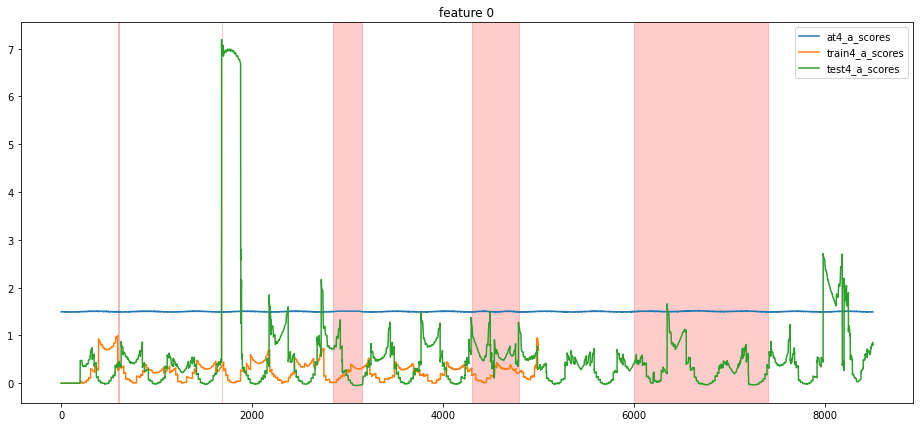

In [11]:
plot_dataset(
    {
        'at4_a_scores': at4_a_scores,
        'train4_a_scores': train4_a_scores['AnomTrans_l1_d3_lambda10'],
        'test4_a_scores': test4_a_scores['AnomTrans_l1_d3_lambda10']
    },
    figsize=(16, 7),
    anoms_vrects=point_anoms_ranges);

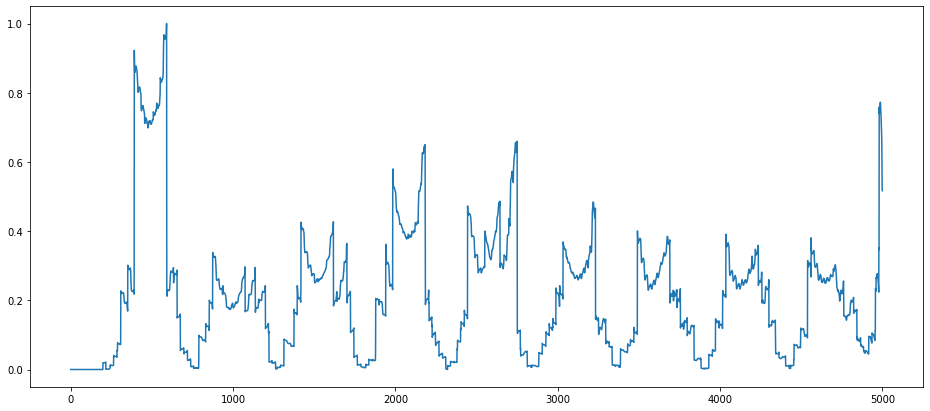

In [ ]:
plot_dataset(
    {'train3_a_scores': train3_a_scores['AnomTrans_l1_d10_lambda3']},
    figsize=(16, 7), show_f_name=False, show_legend=False);

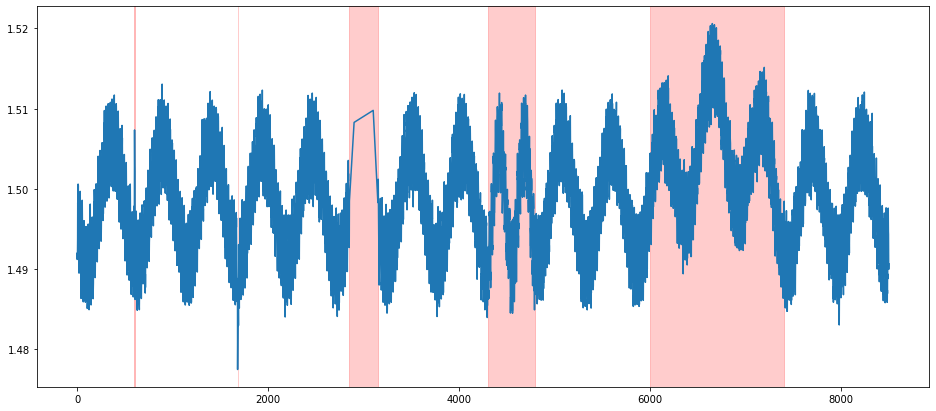

In [12]:
plot_dataset(
    {'at4_a_scores': at4_a_scores,},
    figsize=(16, 7),
    anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

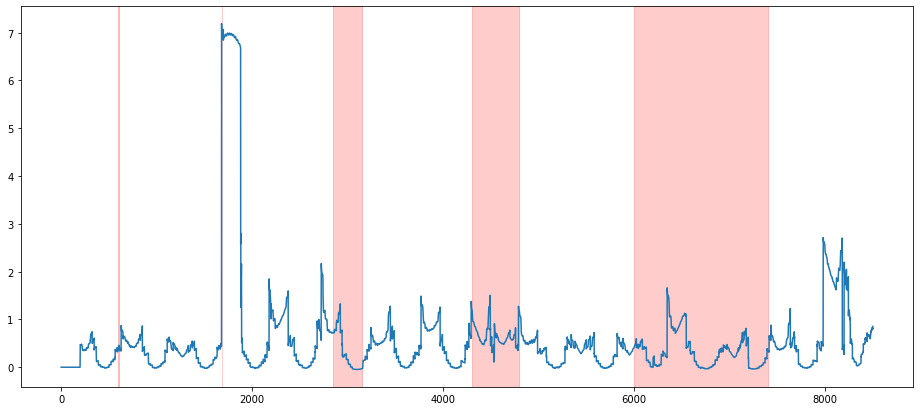

In [13]:
plot_dataset(
    {'test4_a_scores': test4_a_scores['AnomTrans_l1_d3_lambda10']},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

In [ ]:
point_max = pd.DataFrame(at3_a_scores).rolling(window_size).max().fillna(1.5).to_numpy()

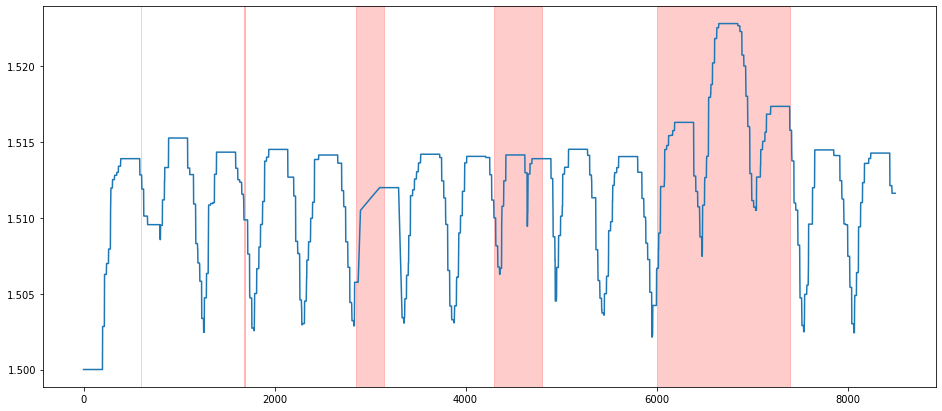

In [ ]:
plot_dataset(
    {'test3_a_scores': point_max},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

In [ ]:
recs = get_a_scores(model, test_dl, scale=False, return_only_point_a_scores=True)

100%|██████████| 17/17 [00:11<00:00,  1.43it/s]


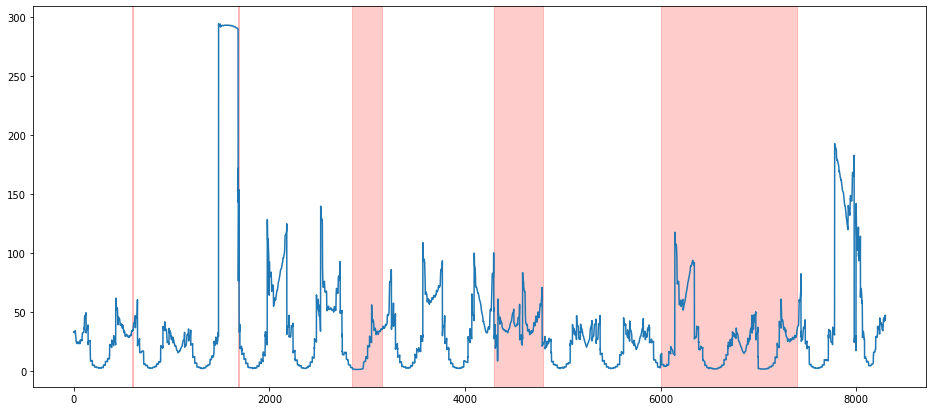

In [ ]:
rec_max = np.max(recs, axis=1).reshape(-1, 1)
plot_dataset(
    {'test3_a_scores': rec_max},
    figsize=(16, 7), anoms_vrects=point_anoms_ranges, show_f_name=False, show_legend=False);

# Getting scores from best model
Best model was ConvAE

In [15]:
exp1 = load_experimentator('./saved_experiments/2022-06-11_22:59:43.pkl')
exp1.models_params['name_']

0                 LSTMMVR_h50_z10_l1
1           Conv_ws200_nk10_ks3_es50
2                    VELC_h50_l1_z10
3    TadGAN_h100_l2_z20_g1d1_warmup0
4          AnomTrans_l3_d512_lambda3
Name: name_, dtype: object

In [17]:
m_name = 'Conv_ws200_nk10_ks3_es50'
model = exp1.load_pl_model(1, f'checkpoints/{ds_name}/{m_name}')

In [18]:
model.fit_scores_scaler(train_dl);

100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


In [20]:
convae_a_scores = get_a_scores(model, test_dl, window_size)

100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


In [34]:
th=1.5
pred_cls = np.array([int(val > th) for val in convae_a_scores])

In [38]:
pred_cls = adjust_point_cls_with_window(pred_cls, window_size, return_point_cls=True)
true_cls = adjust_point_cls_with_window(test_point_cls, window_size, return_point_cls=False)

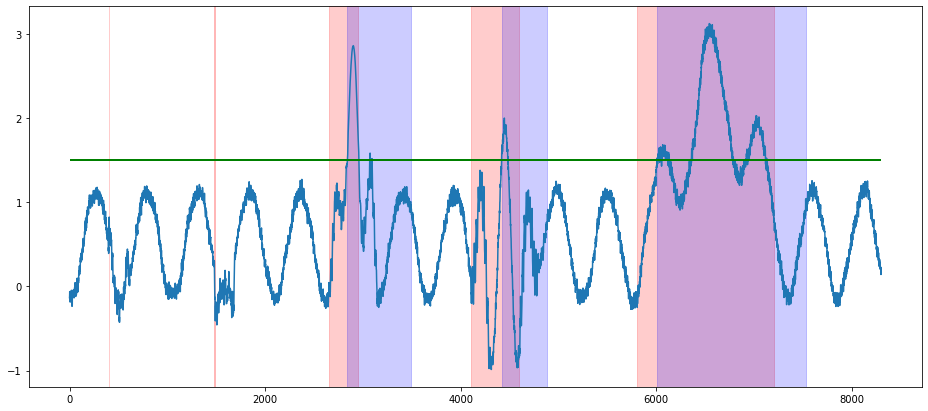

In [39]:
pred_anom_ranges = get_cls_ids_ranges(test_ds.sequences[0].index, pred_cls)
plot_dataset(
    {'conv': convae_a_scores}, figsize=(16,7), hlines={'conv': 1.5},
    anoms_vrects=[
        (start - window_size + 1, end - window_size + 1)
        for start, end in point_anoms_ranges],
    pred_anoms_vrects=[
        (start - window_size + 1, end - window_size + 1)
        for start, end in pred_anom_ranges],
    show_f_name=False, show_legend=False
);